In [2]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy import stats

def add_phase_column(evs):
    """Add phase column to events DataFrame"""
    evs["phase"] = 1
    new_evs = pd.DataFrame()  # Initialize as DataFrame, not list
    for ind, list_evs in evs.groupby('trial'):  # 'trial' is the equivalent of a delivery day
        list_evs = list_evs.copy()  # Avoid SettingWithCopyWarning
        if list_evs['trial'].unique()[0] != -999:
            list_evs['phase'] = 'nan'
            if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty and not list_evs[list_evs['type'] == 'TRIAL_END'].index.empty:
                # find indexes of encoding start and end
                rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
                if not rec_start_indices.empty:
                    rec_start_index = rec_start_indices[0]
                    start_time = list_evs.loc[rec_start_index]['eegoffset']
                    # Find the actual start index based on time condition
                    i = 0
                    rec_start_index_found = True
                    actual_start_index = rec_start_index  # Initialize with default
                    
                    while rec_start_index_found:
                        current_idx = rec_start_index + i
                          #print(i)
                        # Check bounds for iloc access
                        check_time = evs.iloc[current_idx]['eegoffset']  # Use relative index i
                        if check_time - start_time < 3000:
                            i += 1
                            #print(check_time - start_time)
                        else:
                            rec_start_index_found = False
                            actual_start_index = rec_start_index+i
                            #print(i)# Get actual index from list_evs
                    rec_end_indices = list_evs[list_evs['type'] == 'REC_STOP'].index
                    if not rec_end_indices.empty:
                        rec_end_index = rec_end_indices[0]
                        # Now assign to original evs DataFrame using the original indices
                        evs.loc[actual_start_index:rec_end_index, 'phase'] = 'retrieval'
                        #print('get one value', actual_start_index,rec_end_index)
    return evs

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()
subjects=['R1620J', 'R1653J', 'R1693J',
       'R1709J', 'R1724J']
# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
  #  print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
     #    print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Add the phase column
            evs = add_phase_column(evs)
            
            # Add the inside_stimuli variable
            evs['inside_stimuli'] = -999
            stimuli_indices = evs[evs['type'] == 'STIM'].index
            
            for i in stimuli_indices:
                current_offset = evs.loc[i, 'eegoffset']
                evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
                # Keep checking subsequent rows until difference >= 3000
                j = i+1
                rows_to_assign = []  # Store indices of rows to assign
                
                while j < len(evs):
                    next_offset = evs.loc[j, 'eegoffset']
                    time_diff = abs(next_offset - current_offset)
                    #print(time_diff)
                    if time_diff < 3000:
                        # Still within 3 seconds, add this row to assignment list
                        rows_to_assign.append(j)
                        j += 1
                    else:
                        # Found a row with difference >= 4000, stop checking
                        break
                
                # Assign burst_freq to all rows that were within 4000ms of the STIM
                for row_idx in rows_to_assign:
                    evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
                    evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            # Get unique trials for this session
            trials = evs['trial'].unique()
# Find indices of all WORD events
            word_indices = evs[evs['type'] == "WORD"].index

            # Get the events immediately before WORD events
            preceding_events = evs.iloc[word_indices - 1]

            # Find which preceding events are STIM type
            stim_mask = preceding_events['type'] == 'STIM'
            stim_indices = preceding_events[stim_mask].index

            # Update the inside_stimuli column for WORD events that follow STIM events
            for stim_idx in stim_indices:
                word_idx = stim_idx + 1
                burst_freq = evs.loc[stim_idx, 'stim_params']['burst_freq']
                evs.loc[word_idx, 'inside_stimuli'] = burst_freq
                evs.loc[stim_idx, 'inside_stimuli'] = burst_freq
            # Loop through each trial
            for trial in trials:
                if trial != -999 and trial >= 0:  # Skip invalid trials   if trial != -999 and trial >= 0:
                   # print(f"    Processing trial: {trial}")
                    
                    # Filter events for this specific trial
                    trial_evs = evs[evs['trial'] == trial]
                    
                    # Filter for intrusions with additional conditions for this trial
                    intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                                                (trial_evs['type'] == 'REC_WORD') & 
                                                (trial_evs['phase'] == 'retrieval')]
                    none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                                     (trial_evs['type'] == 'REC_WORD') & 
                                                     (trial_evs['phase'] == 'retrieval')]
                    retrieval_phase_events=trial_evs[(trial_evs['phase'] == 'retrieval')]
                    encoding_phase_events=trial_evs[(trial_evs['phase'] != 'retrieval')]
                    # Count intrusions for each stimulation condition
                    intrusion_count_3hz = (intrusion_events['inside_stimuli'] == 3).sum()
                    intrusion_count_8hz = (intrusion_events['inside_stimuli'] == 8).sum()
                    intrusion_count_no_stim = (intrusion_events['inside_stimuli'] == -999).sum()
                    intrusion_count_total = len(intrusion_events)
                    stimi_retrieval_count_3hz = ((retrieval_phase_events['inside_stimuli'] == 3)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_encoding_count_3hz = ((encoding_phase_events['inside_stimuli'] == 3)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_retrieval_count_8hz = ((retrieval_phase_events['inside_stimuli'] == 8)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_encoding_count_8hz = ((encoding_phase_events['inside_stimuli'] == 8)&(trial_evs['type'] == 'STIM')).sum()
                    # Count none intrusions for each stimulation condition
                    none_intrusion_count_3hz = (none_intrusion_events['inside_stimuli'] == 3).sum()
                    none_intrusion_count_8hz = (none_intrusion_events['inside_stimuli'] == 8).sum()
                    none_intrusion_count_no_stim = (none_intrusion_events['inside_stimuli'] == -999).sum()
                    none_intrusion_count_total = len(none_intrusion_events)
                  #  print(none_intrusion_events[['item','inside_stimuli']])
                    DuringSTIM_no=none_intrusion_events['inside_stimuli']==-999
                    No_stimuli_item=none_intrusion_events[DuringSTIM_no]['item']
                    DuringSTIM_yes=(none_intrusion_events['inside_stimuli']==3)|(none_intrusion_events['inside_stimuli']==8)
                    With_stimuli_item=none_intrusion_events[DuringSTIM_yes]['item']
                    Encode_withStimulation_item=trial_evs[(trial_evs['type']=='WORD') & ( (trial_evs['inside_stimuli']==3)| (trial_evs['inside_stimuli']==8))]['item']
                    Encode_without_Stimulation_item=trial_evs[(trial_evs['type']=='WORD') & (trial_evs['inside_stimuli']==-999)]['item']
                    # Convert to sets for efficient intersection operations
                    with_stimuli_set = set(With_stimuli_item)
                    encode_with_stim_set = set(Encode_withStimulation_item)
                    encode_without_stim_set = set(Encode_without_Stimulation_item)
                    no_stimuli_set = set(No_stimuli_item)

                    # Calculate overlaps for With_stimuli_item
                    with_stim_from_encode_with = len(with_stimuli_set.intersection(encode_with_stim_set))
                    with_stim_from_encode_without = len(with_stimuli_set.intersection(encode_without_stim_set))

                    # Calculate overlaps for No_stimuli_item  
                    no_stim_from_encode_with = len(no_stimuli_set.intersection(encode_with_stim_set))
                    no_stim_from_encode_without = len(no_stimuli_set.intersection(encode_without_stim_set))
                    # Store results for this trial
                    trial_result = {
                                'subject': subject,
                                'session': session,
                                'trial': trial,
                                'intrusion_count_3hz': intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'intrusion_count_8hz': intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'intrusion_count_no_stim': intrusion_count_no_stim,
                                'intrusion_count_total': intrusion_count_total,
                                'recall_3hz': none_intrusion_count_3hz if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'recall_8hz': none_intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'recall_no_stim': none_intrusion_count_no_stim,
                                'none_intrusion_count_total': none_intrusion_count_total,
                                'encode_STIM_retrival_STIM_8hz':with_stim_from_encode_with if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_No_retrival_STIM_8hz':with_stim_from_encode_without if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_STIM_retrival_No_8hz':no_stim_from_encode_with if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_No_retrival_No_8hz':no_stim_from_encode_without if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_STIM_retrival_STIM_3hz':with_stim_from_encode_with if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_No_retrival_STIM_3hz':with_stim_from_encode_without if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_STIM_retrival_No_3hz':no_stim_from_encode_with if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_No_retrival_No_3hz':no_stim_from_encode_without if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'stimi_retrieval_count_3hz':stimi_retrieval_count_3hz,
                                'stimi_retrieval_count_8hz':stimi_retrieval_count_8hz,
                                'stimi_encoding_count_3hz':stimi_encoding_count_3hz,
                                'stimi_encoding_count_8hz':stimi_encoding_count_8hz,
                        
                        
                            }
                    results.append(trial_result)
                    
                  #  print(f"      Trial {trial} - Intrusions - 3Hz: {intrusion_count_3hz}, 8Hz: {intrusion_count_8hz}, No stim: {intrusion_count_no_stim}, Total: {intrusion_count_total}")
            
        except Exception as e:
          #  print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("INTRUSION ANALYSIS SUMMARY (BY TRIAL)")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {results_df['session'].nunique()}")
    print(f"Total trials processed: {len(results_df)}")
    print(f"\nIntrusion statistics across all trials:")
    print(f"Mean intrusions per trial:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].mean():.3f} ± {results_df['intrusion_count_3hz'].std():.3f}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].mean():.3f} ± {results_df['intrusion_count_8hz'].std():.3f}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].mean():.3f} ± {results_df['intrusion_count_no_stim'].std():.3f}")
    print(f"  Total: {results_df['intrusion_count_total'].mean():.3f} ± {results_df['intrusion_count_total'].std():.3f}")
    print(f"\nTotal intrusions across all trials:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].sum()}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].sum()}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].sum()}")
    print(f"  Total: {results_df['intrusion_count_total'].sum()}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")


INTRUSION ANALYSIS SUMMARY (BY TRIAL)
Total subjects processed: 5
Total sessions processed: 5
Total trials processed: 41

Intrusion statistics across all trials:
Mean intrusions per trial:
  3Hz stimulation: 0.800 ± 1.196
  8Hz stimulation: 0.409 ± 0.590
  No stimulation: 0.341 ± 0.617
  Total: 0.951 ± 1.244

Total intrusions across all trials:
  3Hz stimulation: 16.0
  8Hz stimulation: 9.0
  No stimulation: 14
  Total: 39

Detailed results:


In [140]:
data_long_8hz

,subject,session,trial,condition,recall_performance,encoding,retrieval
1,R1620J,3,1,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
3,R1620J,3,3,encode_STIM_retrival_STIM_8hz,1.0,1.0,1.0
4,R1620J,3,4,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
6,R1620J,4,1,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
8,R1620J,4,3,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
...,...,...,...,...,...,...,...
156,R1709J,0,3,encode_No_retrival_No_8hz,1.0,0.0,0.0
157,R1709J,1,0,encode_No_retrival_No_8hz,1.0,0.0,0.0
159,R1709J,1,2,encode_No_retrival_No_8hz,0.0,0.0,0.0
161,R1724J,0,1,encode_No_retrival_No_8hz,0.0,0.0,0.0


In [5]:
data_long_8hz = pd.melt(results_df, 
                   id_vars=['subject', 'session','trial'], 
                   value_vars=['encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz', 'encode_STIM_retrival_No_8hz','encode_No_retrival_No_8hz'],
                   var_name='condition', 
                   value_name='recall_performance')


# Create dummy variables for conditions (with no_stim as reference)
# More explicit mapping for clarity
condition_mapping = {
    'encode_STIM_retrival_STIM_8hz': {'encoding': 1, 'retrieval': 1},
    'encode_STIM_retrival_No_8hz': {'encoding': 1, 'retrieval': 0},
    'encode_No_retrival_STIM_8hz': {'encoding': 0, 'retrieval': 1},
    'encode_No_retrival_No_8hz': {'encoding': 0, 'retrieval': 0}  # assuming this condition exists
}

# Apply the mapping
for condition, coding in condition_mapping.items():
    mask = data_long_8hz['condition'] == condition
    data_long_8hz.loc[mask, 'encoding'] = coding['encoding']
    data_long_8hz.loc[mask, 'retrieval'] = coding['retrieval']

# Verify
print("Verification:")
print(data_long_8hz[['condition', 'encoding', 'retrieval']].drop_duplicates().sort_values('condition'))
data_long_8hz = data_long_8hz.dropna(subset=['recall_performance'])

Verification:
                         condition  encoding  retrieval
123      encode_No_retrival_No_8hz       0.0        0.0
41     encode_No_retrival_STIM_8hz       0.0        1.0
82     encode_STIM_retrival_No_8hz       1.0        0.0
0    encode_STIM_retrival_STIM_8hz       1.0        1.0


In [4]:
data_long

NameError: name 'data_long' is not defined

In [6]:
model1 = mixedlm("recall_performance ~ encoding + retrieval + encoding:retrieval", 
                 data_long_8hz, 
                 groups=data_long_8hz["subject"],
                 re_formula="1",
                 vc_formula={"session": "0 + C(session)",
                            "trial": "0 + C(trial)"})
result = model1.fit()
print(result.summary())

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_performance
No. Observations: 88      Method:             REML              
No. Groups:       5       Scale:              0.5364            
Min. group size:  8       Log-Likelihood:     -105.8794         
Max. group size:  28      Converged:          Yes               
Mean group size:  17.6                                          
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.632    0.192  3.289 0.001  0.256  1.009
encoding               0.000    0.221  0.000 1.000 -0.433  0.433
retrieval              0.273    0.221  1.235 0.217 -0.160  0.706
encoding:retrieval    -0.500    0.312 -1.601 0.109 -1.112  0.112
Group Var              0.004    0.181                           
session Var            0.049    0.123  

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
model1 = mixedlm("recall_performance ~ encoding", 
                 data_long_8hz, 
                 groups=data_long_8hz["subject"],
                 re_formula="1",
                 vc_formula={"session": "0 + C(session)",
                            "trial": "0 + C(trial)"})
result = model1.fit()
print(result.summary())

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_performance
No. Observations: 88      Method:             REML              
No. Groups:       5       Scale:              0.5419            
Min. group size:  8       Log-Likelihood:     -106.3201         
Max. group size:  28      Converged:          No                
Mean group size:  17.6                                          
------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept      0.779      0.185    4.204   0.000    0.416    1.142
encoding      -0.250      0.157   -1.593   0.111   -0.558    0.058
Group Var      0.065      0.339                                   
session Var    0.016      0.072                                   
trial Var      0.090      0.125                                   



/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2118: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2130: ConvergenceWarning: Gradient optimization failed, |grad| = 2.083901
  warnings.warn(msg, ConvergenceWarning)


,subject,session,trial,condition,recall_performance,encoding,retrieval
1,R1620J,3,1,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
3,R1620J,3,3,encode_STIM_retrival_STIM_8hz,1.0,1.0,1.0
4,R1620J,3,4,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
6,R1620J,4,1,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
8,R1620J,4,3,encode_STIM_retrival_STIM_8hz,0.0,1.0,1.0
...,...,...,...,...,...,...,...
156,R1709J,0,3,encode_No_retrival_No_8hz,1.0,0.0,0.0
157,R1709J,1,0,encode_No_retrival_No_8hz,1.0,0.0,0.0
159,R1709J,1,2,encode_No_retrival_No_8hz,0.0,0.0,0.0
161,R1724J,0,1,encode_No_retrival_No_8hz,0.0,0.0,0.0


In [137]:
data_long_3hz = pd.melt(results_df, 
                   id_vars=['subject', 'session','trial'], 
                   value_vars=['encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 'encode_STIM_retrival_No_3hz','encode_No_retrival_No_3hz'],
                   var_name='condition', 
                   value_name='recall_performance')


# Create dummy variables for conditions (with no_stim as reference)
# More explicit mapping for clarity
condition_mapping = {
    'encode_STIM_retrival_STIM_3hz': {'encoding': 1, 'retrieval': 1},
    'encode_STIM_retrival_No_3hz': {'encoding': 1, 'retrieval': 0},
    'encode_No_retrival_STIM_3hz': {'encoding': 0, 'retrieval': 1},
    'encode_No_retrival_No_3hz': {'encoding': 0, 'retrieval': 0}  # assuming this condition exists
}

# Apply the mapping
for condition, coding in condition_mapping.items():
    mask = data_long_3hz['condition'] == condition
    data_long_3hz.loc[mask, 'encoding'] = coding['encoding']
    data_long_3hz.loc[mask, 'retrieval'] = coding['retrieval']

# Verify
print("Verification:")
print(data_long_3hz[['condition', 'encoding', 'retrieval']].drop_duplicates().sort_values('condition'))
data_long_3hz = data_long_3hz.dropna(subset=['recall_performance'])
model1 = mixedlm("recall_performance ~ encoding + retrieval + encoding:retrieval", 
                 data_long_3hz, 
                 groups=data_long_3hz["subject"],
                 re_formula="1",
                 vc_formula={"session": "0 + C(session)",
                            "trial": "0 + C(trial)"})
result = model1.fit()
print(result.summary())

Verification:
                         condition  encoding  retrieval
123      encode_No_retrival_No_3hz       0.0        0.0
41     encode_No_retrival_STIM_3hz       0.0        1.0
82     encode_STIM_retrival_No_3hz       1.0        0.0
0    encode_STIM_retrival_STIM_3hz       1.0        1.0
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_performance
No. Observations: 80      Method:             REML              
No. Groups:       5       Scale:              0.8067            
Min. group size:  8       Log-Likelihood:     -112.0878         
Max. group size:  28      Converged:          Yes               
Mean group size:  16.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.717      0.237   3.023   0.003    0.252    1.1

In [117]:
combined = pd.concat([data_long_3hz, data_long_8hz], axis=0, ignore_index=True)
model1 = mixedlm("recall_performance ~ encoding + retrieval + encoding:retrieval", 
                 combined, 
                 groups=combined["subject"],
                 re_formula="1",
                 vc_formula={"session": "0 + C(session)",
                            "trial": "0 + C(trial)"})
result = model1.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_performance
No. Observations: 168     Method:             REML              
No. Groups:       5       Scale:              0.6870            
Min. group size:  16      Log-Likelihood:     -223.7018         
Max. group size:  56      Converged:          No                
Mean group size:  33.6                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.675      0.288   2.349   0.019    0.112    1.239
retrieval       0.131      0.128   1.024   0.306   -0.120    0.382
Group Var       0.302                                             
session Var     0.060      0.100                                  
trial Var       0.128      0.153                                  



In [118]:
summary_stats_3hz= data_long_3hz.groupby(['subject'])['recall_performance'].mean().reset_index()
summary_stats_8hz= data_long_8hz.groupby(['subject'])['recall_performance'].mean().reset_index()

encode_STIM_retrival_STIM_8hz_df['subject'].unique()

array(['R1620J', 'R1653J', 'R1693J', 'R1709J', 'R1724J'], dtype=object)

In [131]:
freq=3
if freq==8:
    encode_STIM_retrival_STIM_8hz_df=results_df.dropna(subset=['encode_STIM_retrival_STIM_8hz'])
    encode_STIM_retrival_No_8hz_df=results_df.dropna(subset=['encode_STIM_retrival_No_8hz'])
    encode_No_retrival_STIM_8hz_df=results_df.dropna(subset=['encode_No_retrival_STIM_8hz'])
    encode_No_retrival_No_8hz_df=results_df.dropna(subset=['encode_No_retrival_No_8hz'])
    summary1_df=encode_STIM_retrival_STIM_8hz_df.groupby(['subject'])['encode_STIM_retrival_STIM_8hz'].mean().reset_index()
    summary2_df=encode_STIM_retrival_No_8hz_df.groupby(['subject'])['encode_STIM_retrival_No_8hz'].mean().reset_index()
    summary3_df=encode_No_retrival_STIM_8hz_df.groupby(['subject'])['encode_No_retrival_STIM_8hz'].mean().reset_index()
    summary4_df=encode_No_retrival_No_8hz_df.groupby(['subject'])['encode_No_retrival_No_8hz'].mean().reset_index()
 
    difference_data = pd.DataFrame({
    'subject': encode_STIM_retrival_STIM_8hz_df['subject'].unique(),
    '++':summary1_df['encode_STIM_retrival_STIM_8hz'],
    '+-': summary2_df['encode_STIM_retrival_No_8hz'],
    '-+': summary3_df['encode_No_retrival_STIM_8hz'],
    '--': summary4_df['encode_No_retrival_No_8hz']})
else:
    encode_STIM_retrival_STIM_3hz_df=results_df.dropna(subset=['encode_STIM_retrival_STIM_3hz'])
    encode_STIM_retrival_No_3hz_df=results_df.dropna(subset=['encode_STIM_retrival_No_3hz'])
    encode_No_retrival_STIM_3hz_df=results_df.dropna(subset=['encode_No_retrival_STIM_3hz'])
    encode_No_retrival_No_3hz_df=results_df.dropna(subset=['encode_No_retrival_No_3hz'])
    summary1_df=encode_STIM_retrival_STIM_3hz_df.groupby(['subject'])['encode_STIM_retrival_STIM_3hz'].mean().reset_index()
    summary2_df=encode_STIM_retrival_No_3hz_df.groupby(['subject'])['encode_STIM_retrival_No_3hz'].mean().reset_index()
    summary3_df=encode_No_retrival_STIM_3hz_df.groupby(['subject'])['encode_No_retrival_STIM_3hz'].mean().reset_index()
    summary4_df=encode_No_retrival_No_3hz_df.groupby(['subject'])['encode_No_retrival_No_3hz'].mean().reset_index()
    difference_data = pd.DataFrame({
        'subject': encode_STIM_retrival_STIM_8hz_df['subject'].unique(),
        '++':summary1_df['encode_STIM_retrival_STIM_3hz'],
        '+-': summary2_df['encode_STIM_retrival_No_3hz'],
        '-+': summary3_df['encode_No_retrival_STIM_3hz'],
        '--': summary4_df['encode_No_retrival_No_3hz']})

In [109]:
difference_data['++']

0    1.000000
1    0.857143
2    1.000000
3    2.000000
4    0.000000
Name: ++, dtype: float64

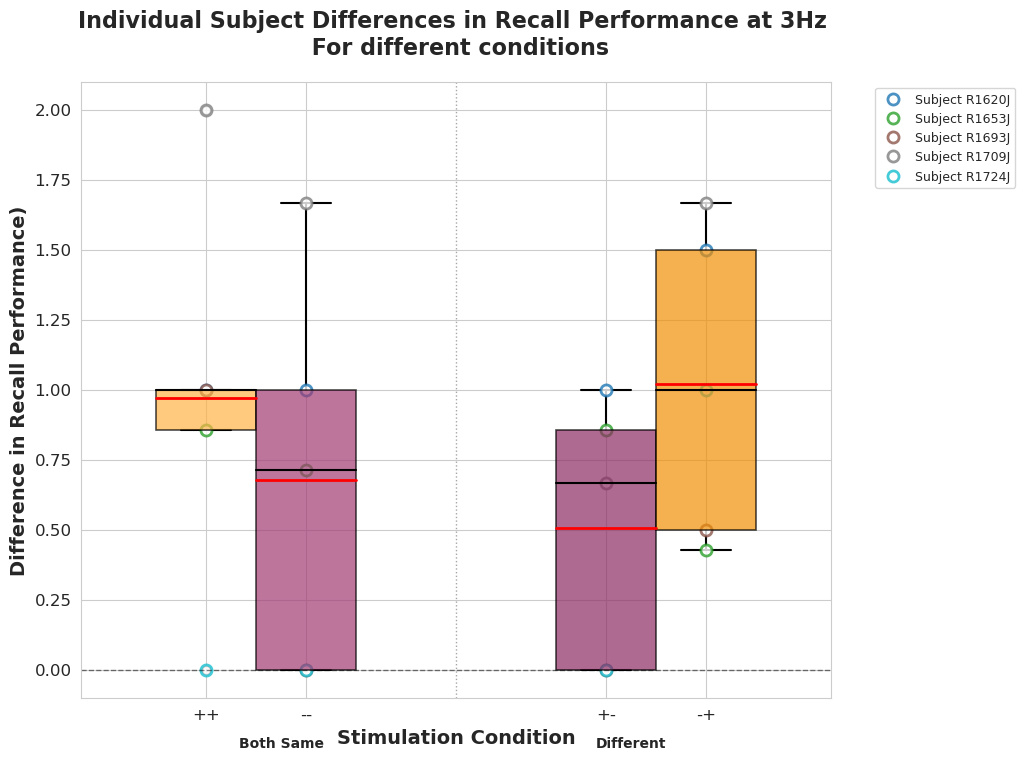

In [132]:
plt.figure(figsize=(12, 8))
# Set up the plot style
sns.set_style("whitegrid")
colors = ['#FFB347','#A23B73', '#8E2B63', '#F18F04'] # Purple for 3Hz, Orange for 8Hz

# Prepare data for box plot - reorder to group conditions logically
box_data = [difference_data['++'], difference_data['--'], difference_data['+-'], difference_data['-+']]

# Create box plot for difference scores - group similar conditions together
x_pos = [0, 0.4, 1.6, 2.0]  # Closer spacing within groups, wider spacing between groups
box_plot = plt.boxplot(box_data, 
                       positions=x_pos,
                       patch_artist=True,
                       widths=0.4,
                       showmeans=True,
                       meanline=True)

# Customize box plot colors
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

# Customize other box plot elements
for element in ['whiskers', 'caps', 'medians']:
    for item in box_plot[element]:
        item.set_color('black')
        item.set_linewidth(1.5)

# Customize mean lines
for item in box_plot['means']:
    item.set_color('red')
    item.set_linewidth(2)
    item.set_linestyle('-')

# Generate distinct colors for each subject
n_subjects = len(difference_data)
if n_subjects <= 10:
    colors_subjects = plt.cm.tab10(np.linspace(0, 1, n_subjects))
elif n_subjects <= 20:
    colors_subjects = plt.cm.tab20(np.linspace(0, 1, n_subjects))
else:
    colors_subjects = plt.cm.viridis(np.linspace(0, 1, n_subjects))

# Plot lines connecting each participant's difference scores
for idx, (_, row) in enumerate(difference_data.iterrows()):
    subject_id = row['subject']
    diffpp = row['++']
    diffpn = row['+-']
    diffnp = row['-+']
    diffnn = row['--']
    
    # Reorder values to match the new x_pos arrangement: ++, --, +-, -+
    plt.plot(x_pos, [diffpp, diffnn, diffpn, diffnp], 
             color=colors_subjects[idx], 
             alpha=0.8, 
             linewidth=0,
             marker='o',
             markersize=8,
             markerfacecolor='white',
             markeredgecolor=colors_subjects[idx],
             markeredgewidth=2,
             zorder=2,
             label=f'Subject {subject_id}')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Add vertical line to separate the two groups
plt.axvline(x=1.0, color='gray', linestyle=':', alpha=0.7, linewidth=1)

# Customize the plot
plt.ylabel('Difference in Recall Performance)', fontsize=14, fontweight='bold')
plt.xlabel('Stimulation Condition', fontsize=14, fontweight='bold')
plt.title('Individual Subject Differences in Recall Performance at '+ str(freq)+ 'Hz \n For different conditions', 
          fontsize=16, fontweight='bold', pad=20)

# Set x-axis labels with grouping
plt.xticks(x_pos, ['++', '--', '+-', '-+'], fontsize=12)

# Add group labels
plt.text(0.3, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.08, 
         'Both Same', ha='center', fontsize=10, fontweight='bold')
plt.text(1.7, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.08, 
         'Different', ha='center', fontsize=10, fontweight='bold')

plt.yticks(fontsize=12)

# Add legend for subjects
if n_subjects <= 15:  # Only add legend if not too many subjects
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.subplots_adjust(right=0.75)  # Make room for legend
else:
    # For many subjects, add a note instead of cluttered legend
    plt.figtext(0.02, 0.95, f'Each colored line represents one of {n_subjects} subjects', 
                fontsize=10, style='italic')
    plt.tight_layout()

plt.show()

In [127]:
diff_summary = pd.DataFrame({
    'condition': ['(++)', '(--)', ' (+-)', ' (-+)'],
    'mean': [difference_data['++'].mean(), difference_data['--'].mean(), difference_data['+-'].mean(), difference_data['-+'].mean()],
    'std': [difference_data['++'].std(), difference_data['--'].std(), difference_data['+-'].std(), difference_data['-+'].std()],
    'sem': [difference_data['++'].sem(), difference_data['--'].sem(), difference_data['+-'].sem(), difference_data['-+'].sem()],
    'count': [len(difference_data['++']), len(difference_data['--']), len(difference_data['+-']), len(difference_data['-+'])]
})

# Calculate 95% confidence intervals
diff_summary['ci_lower'] = diff_summary['mean'] - 1.96 * diff_summary['sem']
diff_summary['ci_upper'] = diff_summary['mean'] + 1.96 * diff_summary['sem']

print("Difference Score Summary Statistics:")
print(diff_summary.round(4))

Difference Score Summary Statistics:
  condition    mean     std     sem  count  ci_lower  ci_upper
0      (++)  0.4190  0.0835  0.0373      5    0.3459    0.4922
1      (--)  0.6905  0.3548  0.1587      5    0.3795    1.0014
2      (+-)  0.6571  0.4802  0.2148      5    0.2362    1.0781
3      (-+)  0.9452  0.7238  0.3237      5    0.3108    1.5797


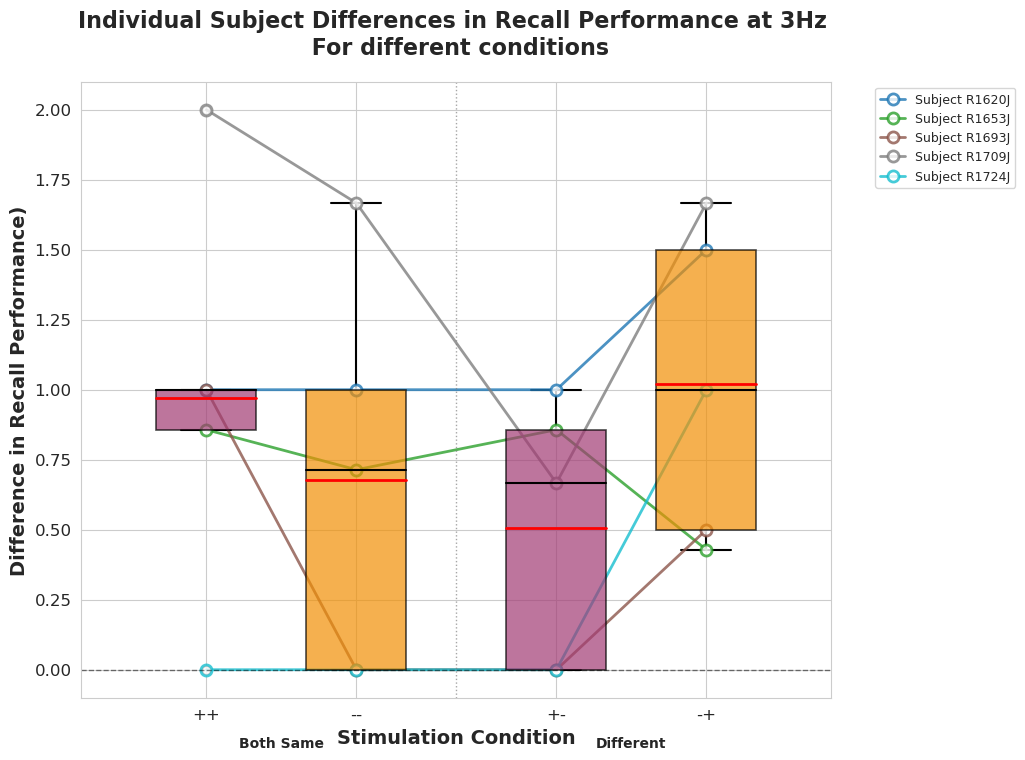

In [94]:
plt.figure(figsize=(12, 8))
# Set up the plot style
sns.set_style("whitegrid")
colors = ['#A23B73', '#F18F04','#A23B74', '#F18F05']  # Purple for 3Hz, Orange for 8Hz

# Prepare data for box plot - reorder to group conditions logically
box_data = [difference_data['++'], difference_data['--'], difference_data['+-'], difference_data['-+']]

# Create box plot for difference scores - group similar conditions together
x_pos = [0, 0.6, 1.4, 2.0]  # Closer spacing within groups, wider spacing between groups
box_plot = plt.boxplot(box_data, 
                       positions=x_pos,
                       patch_artist=True,
                       widths=0.4,
                       showmeans=True,
                       meanline=True)

# Customize box plot colors
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

# Customize other box plot elements
for element in ['whiskers', 'caps', 'medians']:
    for item in box_plot[element]:
        item.set_color('black')
        item.set_linewidth(1.5)

# Customize mean lines
for item in box_plot['means']:
    item.set_color('red')
    item.set_linewidth(2)
    item.set_linestyle('-')

# Generate distinct colors for each subject
n_subjects = len(difference_data)
if n_subjects <= 10:
    colors_subjects = plt.cm.tab10(np.linspace(0, 1, n_subjects))
elif n_subjects <= 20:
    colors_subjects = plt.cm.tab20(np.linspace(0, 1, n_subjects))
else:
    colors_subjects = plt.cm.viridis(np.linspace(0, 1, n_subjects))

# Plot lines connecting each participant's difference scores
for idx, (_, row) in enumerate(difference_data.iterrows()):
    subject_id = row['subject']
    diffpp = row['++']
    diffpn = row['+-']
    diffnp = row['-+']
    diffnn = row['--']
    
    # Reorder values to match the new x_pos arrangement: ++, --, +-, -+
    plt.plot(x_pos, [diffpp, diffnn, diffpn, diffnp], 
             color=colors_subjects[idx], 
             alpha=0.8, 
             linewidth=2,
             marker='o',
             markersize=8,
             markerfacecolor='white',
             markeredgecolor=colors_subjects[idx],
             markeredgewidth=2,
             zorder=2,
             label=f'Subject {subject_id}')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Add vertical line to separate the two groups
plt.axvline(x=1.0, color='gray', linestyle=':', alpha=0.7, linewidth=1)

# Customize the plot
plt.ylabel('Difference in Recall Performance)', fontsize=14, fontweight='bold')
plt.xlabel('Stimulation Condition', fontsize=14, fontweight='bold')
plt.title('Individual Subject Differences in Recall Performance at '+ str(freq)+ 'Hz \n For different conditions', 
          fontsize=16, fontweight='bold', pad=20)

# Set x-axis labels with grouping
plt.xticks(x_pos, ['++', '--', '+-', '-+'], fontsize=12)

# Add group labels
plt.text(0.3, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.08, 
         'Both Same', ha='center', fontsize=10, fontweight='bold')
plt.text(1.7, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.08, 
         'Different', ha='center', fontsize=10, fontweight='bold')

plt.yticks(fontsize=12)

# Add legend for subjects
if n_subjects <= 15:  # Only add legend if not too many subjects
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.subplots_adjust(right=0.75)  # Make room for legend
else:
    # For many subjects, add a note instead of cluttered legend
    plt.figtext(0.02, 0.95, f'Each colored line represents one of {n_subjects} subjects', 
                fontsize=10, style='italic')
    plt.tight_layout()

plt.show()